- (1) intubationtime, extubationtime 인접한 30분 이내 데이터를 삭제하지 않고, 원본데이터는 삭제하지 않고 모두 사용하여야 한다 (subjectlist1도 나중에 수정해야 함)
- (2) filtering 과 alignment 코드는 그대로 사용하면 안됨
- (3) filtering 에서 30분 이내 데이터를 삭제하는 코드가 있음, alignment 에서는 pairing(intubation-extubation 짝을 지어주는 것) 하는 방법만 참고하는 것임.
- (4) 학생들이 unable 시간을 어떤 규칙과 과정으로 생성한 건지 이해하기 어려움
- (5) unable 은 gcs에서 체크 되는 항목이며, unable을 intubation으로 인해 verbal test를 못하는 상황에서 체크되었다고 가정함.
- (6) 하지만 gcs 체크 시간간격은 sparse 한 경우가 많으며 이로 인한 시간차가 크고, gcs에서 unable인 시점에는 intubation 중이므로, 그 전 혹은 그 후에 intubation 또는 extubation이 시행되었다고 볼 수 있다.
- (7-1) 또한, 일반적으로 ventilator(인공호흡기) mode가 CMV인 경우는 intubation 상태라고 여겨지므로, unable time 을 구할때는, gcs에서 체크된 정보와 ventilator mode 정보를 모두 고려하여 전후 시간을 구해야 한다.
- (7-2) unable time 을 어떻게 구했는지에 대해 조건문이 어디에 있는지 확인이 필요함 (rule)
- (8-1) unable로 생성된 intubationtime_un, extubationtime_un 과 intubationtime, extubationtime 을 한 열에다 정렬했을 때 (당연히 원래 정보를 놓치지 않기 위해 별도 컬럼에 표시해야함)
- (8-2) intubation extubation 은 pair 하는 성질이 있으므로 intu -> extu -> intu 처럼 교차로 정보가 나타나야함,
- (8-3) 하지만 intubationtime이(intubationtime_un을 포함해서) 연속해서 나타나거나 extubationtime 이 연속해서 나타나는 것은 에러로 볼 수 있으며 이를 에러 타입별로 정의해야함
- (9) error 타입마다 해결방법을 찾아(rule), 정제함
- (10) 정제한 데이터를 다시 intubation 과 extubation 으로 분리하고 sequence 를 부여함.
- (11) 이후 before 데이터에서 수정할 부분 수정하여
- (12) 두 데이터셋(subjectlist1, subjectlist2)를 비교함

## Subjectlist with temporal imputation using unable data = subjectlist2
GCS의 unable 이 intubation 으로 인해 verbal test 를 못하는 상황에 체크되었다고 가정하고, 이를 이용하여 intubation extubation time 을 추가한다. 이 때 생기는 오류를 정제하여 data reconstruction(temporal imputation)을 한다.

In [1]:
import psycopg2
import pandas as pd
import logging
import sys
import os
from pathlib import Path

# 현재 노트북 파일의 상위 디렉토리에 있는 src 디렉토리의 경로를 sys.path에 추가
module_path = Path('../src').resolve()
if module_path not in sys.path:
    sys.path.append(str(module_path))

# Logging config
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# 소스코드(src)
import src.data_extraction.access_database as db
import src.data_extraction.filter_adult_patients as fap
import src.data_extraction.filter_ventilation_events as fve
# from src_unable.utils import utils

c:\Users\inhae\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


### 1. DB 연결

#### 1-1. DB연결, Intubation/extubation itemid로 데이터 추출

In [2]:
# 데이터 저장위치
output_dir = './data'


# 데이터베이스 연결 설정을 하나의 딕셔너리로 통합
db_config = {
    'database': 'mimiciv',
    'user': 'mai_onlyselect',
    'password': 'student1q2w!@',
    'host': '1.212.63.162',
    'port': '35430'
}

# 호흡기 ITEM ID 설정
vent_ids_config = {
    'INTUBATION_ITEM_IDS': "224385",
    'EXTUBATION_ITEM_IDS': "225468, 225477, 227194"
}

# 테이블 쿼리 설정
tables_query = {
    'pg_tables': 'SELECT * FROM PG_TABLES;',
    'patients': 'SELECT * FROM mimiciv_hosp.patients;',
    'admissions': 'SELECT * FROM mimiciv_hosp.admissions;',
    'transfers': 'SELECT * FROM mimiciv_hosp.transfers;',
    'icustays': 'SELECT * FROM mimiciv_icu.icustays;',
    'd_items': 'SELECT * FROM mimiciv_icu.d_items;',
    'intubation': f"SELECT * FROM mimiciv_icu.procedureevents WHERE itemid IN ({vent_ids_config['INTUBATION_ITEM_IDS']});",
    'extubation': f"SELECT * FROM mimiciv_icu.procedureevents WHERE itemid IN ({vent_ids_config['EXTUBATION_ITEM_IDS']});",
    'ventilation': 'SELECT * FROM mimiciv_derived.ventilation;'
}

# 데이터베이스 연결 함수
def connect_to_database(config):
    try:
        conn = psycopg2.connect(**config)
        print("Connected to the database successfully!")
        return conn
    except (psycopg2.Error, Exception) as error:
        print("Error while connecting to the database:", error)
        return None

# 데이터베이스 연결
conn = connect_to_database(db_config)

if conn is not None:
    # 커서 생성
    cur = conn.cursor()

    # 데이터베이스 작업 수행
    dataframes = db.retrieve_data(conn, tables_query)

    # PostgreSQL 버전 확인
    cur.execute("SELECT version();")
    version = cur.fetchone()
    print("PostgreSQL version:", version)

    # 연결 종료는 필요한 시점에 수행
    # cur.close()
    # conn.close()
else:
    print("Failed to connect to the database.")


2024-10-13 00:54:26,522 - INFO - Retrieved pg_tables: (164, 8)


Connected to the database successfully!


2024-10-13 00:54:30,119 - INFO - Retrieved patients: (299712, 6)
2024-10-13 00:54:48,833 - INFO - Retrieved admissions: (431231, 16)
2024-10-13 00:55:31,326 - INFO - Retrieved transfers: (1890972, 7)
2024-10-13 00:55:34,501 - INFO - Retrieved icustays: (73181, 8)
2024-10-13 00:55:34,763 - INFO - Retrieved d_items: (4014, 9)
2024-10-13 00:55:35,292 - INFO - Retrieved intubation: (8488, 22)
2024-10-13 00:55:36,281 - INFO - Retrieved extubation: (23122, 22)
2024-10-13 00:55:38,199 - INFO - Retrieved ventilation: (109200, 4)


PostgreSQL version: ('PostgreSQL 15.7 (Ubuntu 15.7-1.pgdg22.04+1) on x86_64-pc-linux-gnu, compiled by gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0, 64-bit',)


In [3]:
admissions = dataframes['admissions']

In [4]:
admissions[admissions.hadm_id == 22987108]

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
370,10007818,22987108,2146-06-10 16:37:00,2146-07-12,2146-07-12 20:50:00,DIRECT EMER.,P48GIG,PHYSICIAN REFERRAL,DIED,Medicare,ENGLISH,MARRIED,WHITE,NaT,NaT,1


In [3]:
dataframes.keys()   # 메모리에 저장된 데이터 확인

dict_keys(['pg_tables', 'patients', 'admissions', 'transfers', 'icustays', 'd_items', 'intubation', 'extubation', 'ventilation'])

In [ ]:
# 데이터프레임 변환
patients = dataframes['patients']
admissions = dataframes['admissions']
intubation_all = dataframes['intubation']
extubation_all = dataframes['extubation']
icustays = dataframes['icustays']
ventilation = dataframes['ventilation']

print(f'patients: {patients.shape}')
print(f'admissions: {admissions.shape}')
print(f'intubation_all: {intubation_all.shape}')
print(f'extubation_all: {extubation_all.shape}')
print(f'icustays: {icustays.shape}')
print(f'ventilation: {ventilation.shape}')

patients: (299712, 6)
admissions: (431231, 16)
intubation_all: (8488, 22)
extubation_all: (23122, 22)
icustays: (73181, 8)
ventilation: (109200, 4)


In [5]:
# CSV 파일 저장
patients.to_csv('./data/patients.csv', index=False, encoding='utf-8-sig')
admissions.to_csv('./data/admissions.csv', index=False, encoding='utf-8-sig')
intubation_all.to_csv('./data/intubation_all.csv', index=False, encoding='utf-8-sig')
extubation_all.to_csv('./data/extubation_all.csv', index=False, encoding='utf-8-sig')
icustays.to_csv('./data/icustays.csv', index=False, encoding='utf-8-sig')
ventilation.to_csv('./data/ventilation.csv', index=False, encoding='utf-8-sig')

print("모든 데이터프레임이 CSV 파일로 저장되었습니다.")

모든 데이터프레임이 CSV 파일로 저장되었습니다.


### 2. 데이터 처리
- 2-1. 환자 정보 정제
- 2-2. unable 데이터 찾기
- 2-3. unable 시간으로 intubationtime_un, extubationtime_un 을 생성



#### 2.1. 환자 정보 필터링(선정제외조건)
- 성인 환자 (anchor age >= 18) >>

    - 병원 입원(hadm_id) 정보가 있는 환자 >>
    
        -  중환자실 입원(stay_id) 정보가 있는 환자

In [6]:
## 데이터 처리: 응급병동? 환자 데이터 (filter_adult_patients)
# 성인환자 데이터 필터링(선정제외조건)
adults_pat = fap.filter_adult_patients(patients)   # 18세 이상 필터링
adults_hadm = fap.merge_patient_admissions(adults_pat, admissions)   # patient, admissions 테이블 결합
adults_hadm = fap.remove_missing_hadm(adults_hadm)   # 입원정보(hadm_id) 없는 행 삭제
adults_icu = fap.merge_with_icu(adults_hadm, icustays)   # icu (응급병동?) 테이블 결합
adults_icu = fap.remove_missing_icu_stays(adults_icu)   # icu 입원정보(stay_id) 없는 행 삭제

print(f'Processed adults_icu: {adults_icu.shape}')   # (73181, 13)
print(adults_icu.columns)

Number of adult patients retrieved: 299712
Processed adults_icu: (73181, 13)
Index(['subject_id', 'gender', 'anchor_age', 'hadm_id', 'admittime',
       'dischtime', 'deathtime', 'stay_id', 'first_careunit', 'last_careunit',
       'intime', 'outtime', 'los'],
      dtype='object')


In [7]:
# 데이터 요약
adult_hadm_count = adults_hadm.subject_id.nunique()
adults_icu_count = adults_icu.subject_id.nunique()

print(f'adult patients with hospital admission history: {adult_hadm_count}')
print(f'adult patients with ICU history: {adults_icu_count}')

adult patients with hospital admission history: 180733
adult patients with ICU history: 50920


In [8]:
## 데이터 처리: 삽관/발관 데이터 (filter_ventilation_events)
# 삽관/발관 데이터 필터링 및 처리
intubation_data = fve.filter_and_label_ventilation_data(intubation_all, 'intubationtime', 'intubation')
extubation_data = fve.filter_and_label_ventilation_data(extubation_all, 'extubationtime', 'extubation')

# 삽관 발관 테이블 결합
intubation_extubation = fve.join_ventilation_and_rename(intubation_data, extubation_data)

# 입원 데이터 결합
intubation_extubation = fve.join_admissions(intubation_extubation, admissions)

print(f'Processed intubation_extubation: {intubation_extubation.shape}')   # (10992, 14)
print(intubation_extubation.columns)

print(f'intubation_data: {intubation_data.shape}')
print(f'extubation_data: {extubation_data.shape}')

Processed intubation_extubation: (10668, 13)
Index(['subject_id', 'hadm_id', 'stay_id', 'admittime', 'intubationtime',
       'int_itemid', 'int_weight', 'extubationtime', 'ext_itemid',
       'ext_weight', 'extubationcause', 'dischtime', 'deathtime'],
      dtype='object')
intubation_data: (8488, 6)
extubation_data: (23122, 7)


In [9]:
intubation_data.to_csv('./data/intubation_data_before_unable.csv', index=True)
extubation_data.to_csv('./data/extubation_data_before_unable.csv', index=True)
intubation_extubation.to_csv('./data/intubation_extubation_before_unable.csv', index=True)

In [12]:
intubation_extubation.head(5)

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime
0,10094805,21370539,34488364,2182-04-23 19:14:00,2182-04-25 12:22:00,224385,65.9,34488364.0,2182-04-28 13:15:00,227194.0,65.9,Planned Extubation,2182-05-09 13:20:00,2182-05-09 13:20:00
1,10095570,28612694,37685093,2148-09-26 03:38:00,2148-09-28 18:33:00,224385,75.0,NaN,NaT,NaN,NaN,NaN,2148-09-29 10:50:00,2148-09-29 10:50:00
2,10098215,20652197,37703075,2118-08-14 20:31:00,2118-09-02 07:45:00,224385,66.0,37703075.0,2118-09-05 11:20:00,227194.0,66.0,Planned Extubation,2118-09-18 15:15:00,NaT
3,10098215,21701015,30598744,2118-01-10 03:42:00,2118-01-10 13:09:00,224385,57.0,30598744.0,2118-01-11 09:55:00,227194.0,57.0,Planned Extubation,2118-02-13 19:00:00,NaT
4,10098215,22394571,32301420,2118-05-03 23:07:00,2118-06-18 01:48:00,224385,48.7,32301420.0,2118-06-21 03:30:00,225468.0,48.7,Unplanned Extubation (patient-initiated),2118-07-16 12:15:00,NaT


#### 2.2.Unable 데이터 구성

2.2.1. intubation_extubation_data 불러와서 subjectlist 생성

In [13]:
# 이미 생성된 intubation_extubation 파일 불러오기
subjectlist = pd.read_csv('./data/intubation_extubation_before_unable.csv', parse_dates=['admittime', 'intubationtime', 'extubationtime', 'dischtime', 'deathtime'], index_col=0)

# 데이터 확인
print(f"Loaded subjectlist shape: {subjectlist.shape}")
print(subjectlist.columns)
print(subjectlist.head())
print(subjectlist.info())

# 필요한 경우 subjectlist를 저장
subjectlist.to_csv('./data/subjectlist_before_unable.csv', index=True)

Loaded subjectlist shape: (11528, 14)
Index(['subject_id', 'hadm_id', 'int_stayid', 'admittime', 'intubationtime',
       'int_itemid', 'int_weight', 'ext_stayid', 'extubationtime',
       'ext_itemid', 'ext_weight', 'extubationcause', 'dischtime',
       'deathtime'],
      dtype='object')
   subject_id   hadm_id  int_stayid           admittime      intubationtime  \
0    10094805  21370539    34488364 2182-04-23 19:14:00 2182-04-25 12:22:00   
1    10095570  28612694    37685093 2148-09-26 03:38:00 2148-09-28 18:33:00   
2    10098215  20652197    37703075 2118-08-14 20:31:00 2118-09-02 07:45:00   
3    10098215  21701015    30598744 2118-01-10 03:42:00 2118-01-10 13:09:00   
4    10098215  22394571    32301420 2118-05-03 23:07:00 2118-06-18 01:48:00   

   int_itemid  int_weight  ext_stayid      extubationtime  ext_itemid  \
0      224385        65.9  34488364.0 2182-04-28 13:15:00    227194.0   
1      224385        75.0         NaN                 NaT         NaN   
2      224385 

In [14]:
subjectlist.head(5)

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime
0,10094805,21370539,34488364,2182-04-23 19:14:00,2182-04-25 12:22:00,224385,65.9,34488364.0,2182-04-28 13:15:00,227194.0,65.9,Planned Extubation,2182-05-09 13:20:00,2182-05-09 13:20:00
1,10095570,28612694,37685093,2148-09-26 03:38:00,2148-09-28 18:33:00,224385,75.0,NaN,NaT,NaN,NaN,NaN,2148-09-29 10:50:00,2148-09-29 10:50:00
2,10098215,20652197,37703075,2118-08-14 20:31:00,2118-09-02 07:45:00,224385,66.0,37703075.0,2118-09-05 11:20:00,227194.0,66.0,Planned Extubation,2118-09-18 15:15:00,NaT
3,10098215,21701015,30598744,2118-01-10 03:42:00,2118-01-10 13:09:00,224385,57.0,30598744.0,2118-01-11 09:55:00,227194.0,57.0,Planned Extubation,2118-02-13 19:00:00,NaT
4,10098215,22394571,32301420,2118-05-03 23:07:00,2118-06-18 01:48:00,224385,48.7,32301420.0,2118-06-21 03:30:00,225468.0,48.7,Unplanned Extubation (patient-initiated),2118-07-16 12:15:00,NaT


In [15]:
# unable 데이터를 위한 subjectlist 생성
sublist_for_unable = subjectlist[['subject_id', 'hadm_id', 'int_stayid']].copy()
sublist_for_unable['stay_id'] = sublist_for_unable['int_stayid']

print("sublist_for_unable shape:", sublist_for_unable.shape)
print("sublist_for_unable columns:", sublist_for_unable.columns)
print(sublist_for_unable.head())

sublist_for_unable shape: (11528, 4)
sublist_for_unable columns: Index(['subject_id', 'hadm_id', 'int_stayid', 'stay_id'], dtype='object')
   subject_id   hadm_id  int_stayid   stay_id
0    10094805  21370539    34488364  34488364
1    10095570  28612694    37685093  37685093
2    10098215  20652197    37703075  37703075
3    10098215  21701015    30598744  30598744
4    10098215  22394571    32301420  32301420


2.2.2 reconstruction을 위한 데이터들 추출
- 이때, gcs에서는 na가 아닌 데이터를 추출한다
- LAB은 중복을 제거한다
- vital 은 mbp 계산 가능한 것들 계산해서 채운다

In [16]:
# 데이터 추출을 위한 쿼리 정의
queries_for_unable = {
    'lab_abga': """
        SELECT * FROM mimiciv_hosp.labevents 
        WHERE itemid IN (50818, 50820, 50821, 50802, 50817, 50882);
    """,
    'ventilator_setting': "SELECT * FROM mimiciv_derived.ventilator_setting;",
    'ventilation': "SELECT * FROM mimiciv_derived.ventilation;",
    'gcs': "SELECT * FROM mimiciv_derived.gcs;",
    'vitalsign': "SELECT * FROM mimiciv_derived.vitalsign;",
    'icustays': "SELECT * FROM mimiciv_icu.icustays;"
}

# 데이터베이스에서 데이터 가져오기
retrieved_data = db.retrieve_data(conn, queries_for_unable)

# 각 데이터프레임 할당
lab_abga = retrieved_data['lab_abga']
ventilator_setting = retrieved_data['ventilator_setting']
ventilation = retrieved_data['ventilation']
gcs = retrieved_data['gcs']
vitalsign = retrieved_data['vitalsign']
icustays = retrieved_data['icustays']

# icustays 데이터 전처리
icustays['intime'] = pd.to_datetime(icustays['intime'])
icustays['outtime'] = pd.to_datetime(icustays['outtime'])

# 데이터 추출 결과 로그 출력
for name, df in retrieved_data.items():
    print(f"Retrieved {name}: {df.shape}")

2024-10-11 18:07:23,471 - INFO - Retrieved lab_abga: (5248946, 16)
2024-10-11 18:08:05,650 - INFO - Retrieved ventilator_setting: (1006127, 17)
2024-10-11 18:08:09,349 - INFO - Retrieved ventilation: (109200, 4)
2024-10-11 18:08:38,654 - INFO - Retrieved gcs: (1637763, 8)
2024-10-11 18:13:47,754 - INFO - Retrieved vitalsign: (9745500, 15)
2024-10-11 18:14:05,743 - INFO - Retrieved icustays: (73181, 8)


Retrieved lab_abga: (5248946, 16)
Retrieved ventilator_setting: (1006127, 17)
Retrieved ventilation: (109200, 4)
Retrieved gcs: (1637763, 8)
Retrieved vitalsign: (9745500, 15)
Retrieved icustays: (73181, 8)


In [17]:
# subjectlist를 이용한 데이터 전처리 함수들
def process_vitals(sublist_for_unable, vitalsign):
    sub_vitals = sublist_for_unable.merge(vitalsign, on=['subject_id', 'stay_id'], how='left')
    
    def calculate_mbp(row):
        if pd.isna(row['mbp']) and pd.notna(row['sbp']) and pd.notna(row['dbp']):
            return (row['sbp'] + 2 * row['dbp']) / 3
        return row['mbp']
    
    def calculate_sbp(row):
        if pd.isna(row['sbp']) and pd.notna(row['mbp']) and pd.notna(row['dbp']):
            return 3 * row['mbp'] - 2 * row['dbp']
        return row['sbp']
    
    def calculate_dbp(row):
        if pd.isna(row['dbp']) and pd.notna(row['mbp']) and pd.notna(row['sbp']):
            return (3 * row['mbp'] - row['sbp']) / 2
        return row['dbp']
    
    sub_vitals['mbp'] = sub_vitals.apply(calculate_mbp, axis=1)
    sub_vitals['sbp'] = sub_vitals.apply(calculate_sbp, axis=1)
    sub_vitals['dbp'] = sub_vitals.apply(calculate_dbp, axis=1)
    
    return sub_vitals

def process_ventset(sublist_for_unable, ventilator_setting):
    return sublist_for_unable.merge(ventilator_setting, on=['subject_id', 'stay_id'], how='left')


def process_gcs(sublist_for_unable, gcs):
    sub_gcs = sublist_for_unable.merge(gcs, on=['subject_id', 'stay_id'], how='left')
    sub_gcs_notna = sub_gcs[sub_gcs.gcs.notna()]
    sub_gcs_notna['gcs_m_e'] = sub_gcs_notna['gcs_motor'] + sub_gcs_notna['gcs_eyes']
    return sub_gcs_notna


def process_lab(sublist_for_unable, lab_abga, icustays):
    sub_abga = sublist_for_unable.merge(lab_abga, on=['subject_id', 'hadm_id'], how='left')
    sub_abga['charttime'] = pd.to_datetime(sub_abga['charttime'])
    sub_abga = sub_abga.sort_values(by=['subject_id', 'hadm_id', 'charttime'])

    # 전체 중복 제거
    sub_abga_unique_tmp = sub_abga.drop_duplicates()

    # stay_id를 제외한 모든 열을 그룹화
    group_columns = sub_abga_unique_tmp.columns.difference(['stay_id']).tolist()

    # 그룹화하여 중복된 데이터 찾기(stay_id만 다르고 모든 데이터 동일)
    sub_abga_unique_tmp['is_duplicated'] = sub_abga_unique_tmp.duplicated(subset=group_columns, keep=False)

    # 중복된 데이터만 필터링
    duplicated_groups = sub_abga_unique_tmp[sub_abga_unique_tmp['is_duplicated']]

    # 데이터 병합
    merged_df = pd.merge(duplicated_groups, icustays, on=['subject_id', 'hadm_id', 'stay_id'], how='inner')

    # datetime 형식 변환
    for col in ['charttime', 'intime', 'outtime']:
        if col in merged_df.columns:
            merged_df[col] = pd.to_datetime(merged_df[col])

    # charttime이 intime과 outtime 사이에 있는 행만 필터링
    filtered_df = merged_df[(merged_df['charttime'] >= merged_df['intime']) & (merged_df['charttime'] <= merged_df['outtime'])]

    # icustays테이블의 컬럼들 삭제
    columns_to_drop = ['first_careunit', 'last_careunit', 'intime', 'outtime', 'los', 'is_duplicated']
    final_df = filtered_df.drop(columns=[col for col in columns_to_drop if col in filtered_df.columns])

    # is_duplicated 컬럼이 True인 것을 모두 삭제하고, final_df와 병합
    sub_abga_unique = pd.concat([final_df, sub_abga_unique_tmp[~sub_abga_unique_tmp.index.isin(duplicated_groups.index)]])

    # 다시 정렬
    sub_abga_unique = sub_abga_unique.sort_values(by=['subject_id', 'hadm_id', 'charttime'])
    sub_abga_unique['charttime'] = pd.to_datetime(sub_abga_unique['charttime'])
    if 'storetime' in sub_abga_unique.columns:
        sub_abga_unique['storetime'] = pd.to_datetime(sub_abga_unique['storetime'])

    return sub_abga_unique

In [18]:
# 필요한 데이터 불러오기 (예시)
# sublist_for_unable = pd.read_csv('path_to_sublist.csv')
# vitalsign = pd.read_csv('path_to_vitalsign.csv')
# ventilator_setting = pd.read_csv('path_to_ventilator_setting.csv')
# gcs = pd.read_csv('path_to_gcs.csv')
# lab_abga = pd.read_csv('path_to_lab_abga.csv')
# icustays = pd.read_csv('path_to_icustays.csv')

# 함수 호출 및 결과 저장
sub_vitals = process_vitals(sublist_for_unable, vitalsign)
sub_ventset = process_ventset(sublist_for_unable, ventilator_setting)
sub_gcs_notna = process_gcs(sublist_for_unable, gcs)
sub_abga_unique = process_lab(sublist_for_unable, lab_abga, icustays)

# 결과 저장
sub_vitals.to_csv('./data/sub_vitals.csv', index=True, encoding='utf-8-sig')
sub_gcs_notna.to_csv('./data/sub_gcs_notna.csv', index=True, encoding='utf-8-sig')
sub_ventset.to_csv('./data/sub_ventset.csv', index=True, encoding='utf-8-sig')
sub_abga_unique.to_csv('./data/sub_abga_unique.csv', index=True, encoding='utf-8-sig')
icustays.to_csv('./data/icustays.csv', index=True, encoding='utf-8-sig')

print("All processed data files have been saved.")

C:\Users\inhae\AppData\Local\Temp\ipykernel_3432\3449050282.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_gcs_notna['gcs_m_e'] = sub_gcs_notna['gcs_motor'] + sub_gcs_notna['gcs_eyes']
C:\Users\inhae\AppData\Local\Temp\ipykernel_3432\3449050282.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_abga_unique_tmp['is_duplicated'] = sub_abga_unique_tmp.duplicated(subset=group_columns, keep=False)


All processed data files have been saved.


In [46]:
sub_gcs_notna[sub_gcs_notna.stay_id == 35451334].charttime.sort_values()

467047   2141-01-21 18:09:00
467048   2141-01-21 20:00:00
467049   2141-01-22 00:00:00
467050   2141-01-22 04:00:00
467051   2141-01-22 07:30:00
                 ...        
467150   2141-02-08 00:00:00
467151   2141-02-08 04:00:00
467152   2141-02-08 08:56:00
467153   2141-02-08 12:25:00
467154   2141-02-08 16:04:00
Name: charttime, Length: 108, dtype: datetime64[ns]

In [19]:
import pandas as pd

# 5개 파일 읽기
sub_vitals = pd.read_csv('./data/sub_vitals.csv', encoding='utf-8-sig', index_col=0)
sub_gcs_notna = pd.read_csv('./data/sub_gcs_notna.csv', encoding='utf-8-sig', index_col=0)
sub_ventset = pd.read_csv('./data/sub_ventset.csv', encoding='utf-8-sig', index_col=0)
sub_abga_unique = pd.read_csv('./data/sub_abga_unique.csv', encoding='utf-8-sig', index_col=0)
icustays = pd.read_csv('./data/icustays.csv', encoding='utf-8-sig', index_col=0)

# 각 데이터프레임의 기본 정보 출력
for name, df in [('sub_vitals', sub_vitals), 
                 ('sub_gcs_notna', sub_gcs_notna), 
                 ('sub_ventset', sub_ventset), 
                 ('sub_abga_unique', sub_abga_unique), 
                 ('icustays', icustays)]:
    print(f"\n{name} shape: {df.shape}")
    print(f"{name} columns: {df.columns.tolist()}")
    print(f"{name} first few rows:")
    print(df.head())
    print("-" * 50)

C:\Users\inhae\AppData\Local\Temp\ipykernel_3432\2458550792.py:7: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  sub_abga_unique = pd.read_csv('./data/sub_abga_unique.csv', encoding='utf-8-sig', index_col=0)



sub_vitals shape: (4852818, 17)
sub_vitals columns: ['subject_id', 'hadm_id', 'int_stayid', 'stay_id', 'charttime', 'heart_rate', 'sbp', 'dbp', 'mbp', 'sbp_ni', 'dbp_ni', 'mbp_ni', 'resp_rate', 'temperature', 'temperature_site', 'spo2', 'glucose']
sub_vitals first few rows:
   subject_id   hadm_id  int_stayid   stay_id            charttime  \
0    10094805  21370539    34488364  34488364  2182-04-23 19:23:00   
1    10094805  21370539    34488364  34488364  2182-04-23 19:24:00   
2    10094805  21370539    34488364  34488364  2182-04-23 19:25:00   
3    10094805  21370539    34488364  34488364  2182-04-23 19:30:00   
4    10094805  21370539    34488364  34488364  2182-04-23 20:00:00   

   heart_rate    sbp   dbp   mbp  sbp_ni  dbp_ni  mbp_ni  resp_rate  \
0         NaN  115.0  68.0  77.0   115.0    68.0    77.0        NaN   
1        92.0    NaN   NaN   NaN     NaN     NaN     NaN       23.0   
2         NaN    NaN   NaN   NaN     NaN     NaN     NaN        NaN   
3        91.0    Na

#### 2.3 unable 시간으로 intubationtime(un), extubationtime(un) 을 생성

In [20]:
#그 전에 ventilator 의 mode 가 복잡하므로 이를 1~4 단계로 나누었다. 이를 mapping 하는 코드는 아래 경로에 있다.
from src.ventilator_mode_mapping import ventilator_mapping as vm   # ventset_maaping 

- gcs 는 m + e + v 이지만, m + e 만 여기서 쓰도록 함.

In [21]:
import pandas as pd
import numpy as np

# 기존의 sub_gcs_notna 파일 로드
sub_gcs_notna = pd.read_csv('./data/sub_gcs_notna.csv', parse_dates=['charttime'])

# 에러 수정 및 새로운 컬럼 추가
def correct_gcs_errors(df):
    # error 1: gcs_verbal이 0이고 gcs_unable이 0인 경우, gcs_unable을 1로 설정
    df.loc[(df.gcs_verbal == 0) & (df.gcs_unable == 0), 'gcs_unable'] = 1
    
    # error 2: gcs_verbal이 NA인 경우, gcs_unable을 1로 설정
    df.loc[df.gcs_verbal.isna(), 'gcs_unable'] = 1
    
    # motor와 eyes만 가지고 총합 재설정
    df['gcs_m_e'] = df['gcs_motor'] + df['gcs_eyes']
    
    return df

# 함수 적용
sub_gcs_me = correct_gcs_errors(sub_gcs_notna)

# 정렬 적용
sub_gcs_me = sub_gcs_me.sort_values(by=['subject_id', 'hadm_id', 'charttime'])

# 결과 저장
sub_gcs_me.to_csv('./data/sub_gcs_me.csv', index=False)

print("File 'sub_gcs_me.csv' has been created successfully.")

File 'sub_gcs_me.csv' has been created successfully.


<class 'pandas.core.frame.DataFrame'>
Index: 821289 entries, 814137 to 811719
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Unnamed: 0  821289 non-null  int64         
 1   subject_id  821289 non-null  int64         
 2   hadm_id     821289 non-null  int64         
 3   int_stayid  821289 non-null  int64         
 4   stay_id     821289 non-null  int64         
 5   charttime   821289 non-null  datetime64[ns]
 6   gcs         821289 non-null  float64       
 7   gcs_motor   818854 non-null  float64       
 8   gcs_verbal  819601 non-null  float64       
 9   gcs_eyes    820463 non-null  float64       
 10  gcs_unable  821289 non-null  float64       
 11  gcs_m_e     818207 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(5)
memory usage: 81.5 MB
None
          Unnamed: 0    subject_id       hadm_id    int_stayid       stay_id  \
count  821289.000000  8.212890e+05  8.212890e+05

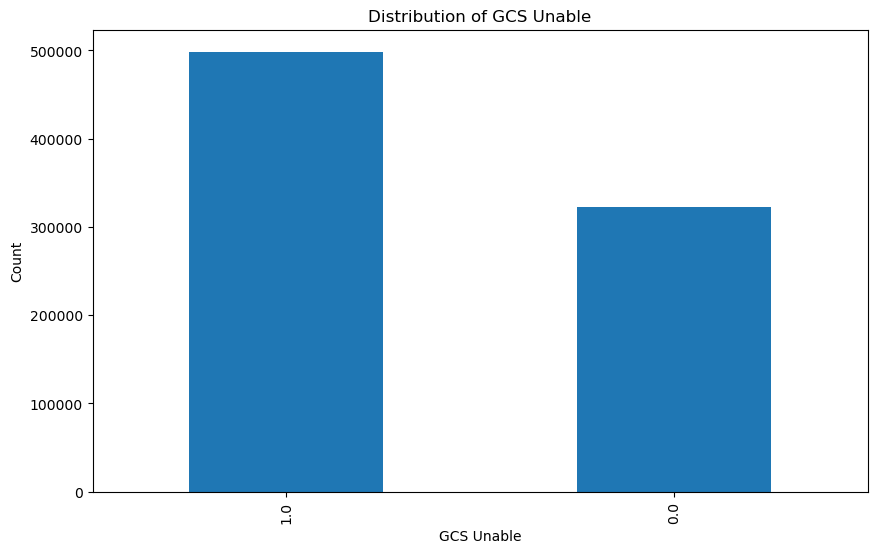

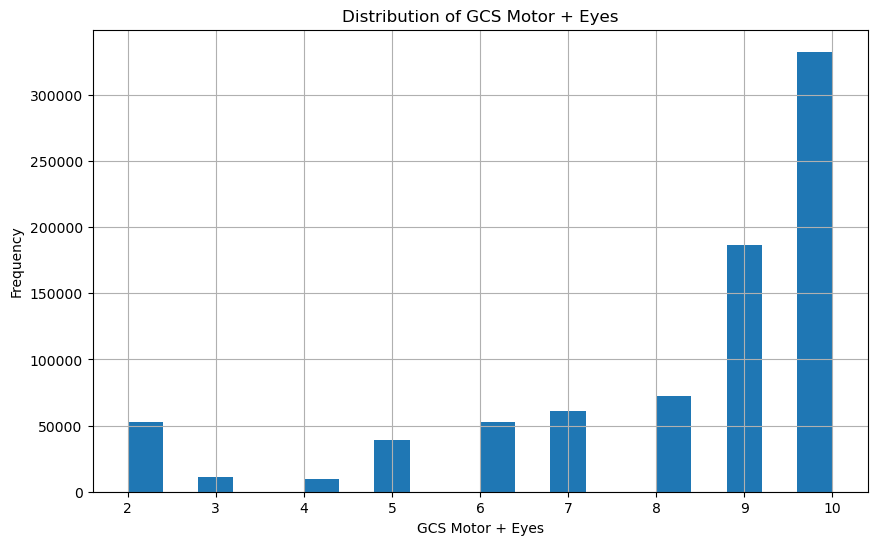

In [22]:
# sub_gcs_me.csv 생성 후 바로 아래에 추가
print(sub_gcs_me.info())
print(sub_gcs_me.describe())

# gcs_unable의 분포 확인
unable_counts = sub_gcs_me['gcs_unable'].value_counts()
print("GCS Unable Distribution:")
print(unable_counts)

import matplotlib.pyplot as plt

# gcs_unable의 분포 시각화
plt.figure(figsize=(10, 6))
unable_counts.plot(kind='bar')
plt.title('Distribution of GCS Unable')
plt.xlabel('GCS Unable')
plt.ylabel('Count')
plt.show()

# gcs_m_e의 분포 시각화
plt.figure(figsize=(10, 6))
sub_gcs_me['gcs_m_e'].hist(bins=20)
plt.title('Distribution of GCS Motor + Eyes')
plt.xlabel('GCS Motor + Eyes')
plt.ylabel('Frequency')
plt.show()

#### unablestarttime, stoptime, seq 컬럼추가 (unabletime 생성위함)
- unablestarttime: unable이 1로 전환된 시점 -> intubationtime(un)으로 컬럼 이름 변경
- unablestoptime: unable이 0으로 전환되기 전 시점 -> extubationtime(un)으로 컬럼 이름 변경
- unableseq: stay_id 기준으로 순서 부여

In [23]:
def find_unable_periods(df):
    results = []

    # subject_id, hadm_id, stay_id 그룹화
    grouped = df.sort_values(['subject_id', 'hadm_id', 'stay_id', 'charttime']).groupby(['subject_id', 'hadm_id'])

    for (subject_id, hadm_id), group in grouped:
        # stay_id로 짜르기
        stay_grouped = group.groupby('stay_id')
        
        for stay_id, stay_group in stay_grouped:
            stay_group = stay_group.sort_values('charttime') 
            unablestarttime = None
            unableseq = 0

            for i in range(len(stay_group)):
                # gcs_unable이 1이 되었을 때의 시간
                if stay_group.iloc[i]['gcs_unable'] == 1 and (i == 0 or stay_group.iloc[i - 1]['gcs_unable'] == 0):
                    unablestarttime = stay_group.iloc[i]['charttime']
                    unableseq += 1

                # gcs_unable이 0이 되었을 때의 시간 
                elif stay_group.iloc[i]['gcs_unable'] == 0 and (i > 0 and stay_group.iloc[i - 1]['gcs_unable'] == 1):
                    unablestoptime = stay_group.iloc[i - 1]['charttime']
                    results.append({
                        'subject_id': subject_id,
                        'hadm_id': hadm_id,
                        'stay_id': stay_id,
                        'intubationtime(un)': unablestarttime,
                        'extubationtime(un)': unablestoptime,
                        'unableseq': unableseq
                    })
                    unablestarttime = None

            # 마지막까지 unable이 1인 경우 마지막을 extubationtime(un)으로
            if stay_group.iloc[-1]['gcs_unable'] == 1 and unablestarttime is not None:
                unablestoptime = stay_group.iloc[-1]['charttime']
                results.append({
                    'subject_id': subject_id,
                    'hadm_id': hadm_id,
                    'stay_id': stay_id,
                    'intubationtime(un)': unablestarttime,
                    'extubationtime(un)': unablestoptime,
                    'unableseq': unableseq
                })
    
    return pd.DataFrame(results)


result_df = find_unable_periods(sub_gcs_me)
result_df

,subject_id,hadm_id,stay_id,intubationtime(un),extubationtime(un),unableseq
0,10001884,26184834,37510196,2131-01-11 08:00:00,2131-01-12 17:30:00,1
1,10001884,26184834,37510196,2131-01-13 04:00:00,2131-01-13 20:00:00,2
2,10001884,26184834,37510196,2131-01-14 08:08:00,2131-01-17 20:09:00,3
3,10001884,26184834,37510196,2131-01-19 00:00:00,2131-01-19 08:00:00,4
4,10003400,23559586,38383343,2137-08-18 02:00:00,2137-08-21 16:00:00,1
...,...,...,...,...,...,...
17635,19999068,21606769,30143796,2161-08-25 17:13:00,2161-08-27 04:56:00,1
17636,19999068,21606769,30143796,2161-08-27 19:30:00,2161-08-28 12:38:00,2
17637,19999442,26785317,32336619,2148-11-19 23:00:00,2148-11-20 13:00:00,1
17638,19999840,21033226,38978960,2164-09-12 10:11:00,2164-09-12 16:00:00,1


In [24]:
result_df.to_csv('./data/unable_periods.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17640 entries, 0 to 17639
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   subject_id          17640 non-null  int64         
 1   hadm_id             17640 non-null  int64         
 2   stay_id             17640 non-null  int64         
 3   intubationtime(un)  17640 non-null  datetime64[ns]
 4   extubationtime(un)  17640 non-null  datetime64[ns]
 5   unableseq           17640 non-null  int64         
dtypes: datetime64[ns](2), int64(4)
memory usage: 827.0 KB
None
         subject_id       hadm_id       stay_id  \
count  1.764000e+04  1.764000e+04  1.764000e+04   
mean   1.508611e+07  2.507131e+07  3.496863e+07   
min    1.000188e+07  2.000136e+07  3.000115e+07   
25%    1.272125e+07  2.249772e+07  3.246012e+07   
50%    1.514923e+07  2.518118e+07  3.494151e+07   
75%    1.752190e+07  2.757398e+07  3.746081e+07   
max    1.999984e+07  2.

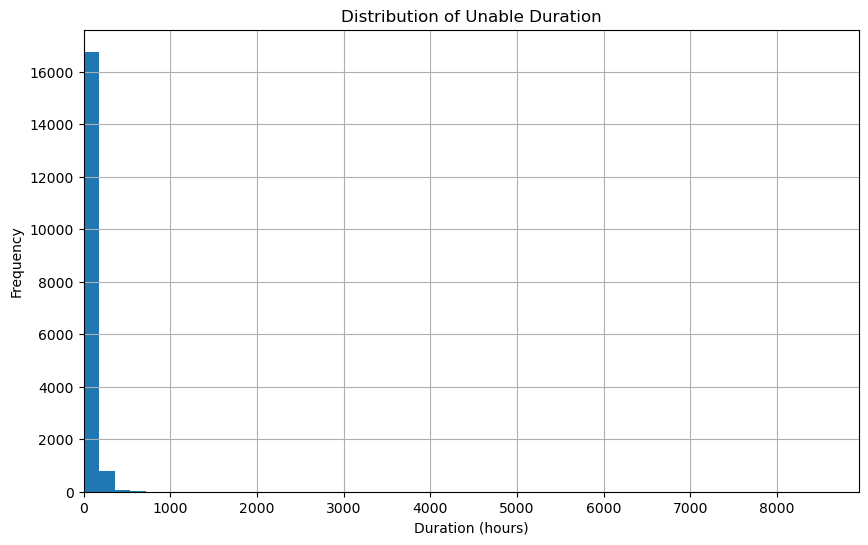

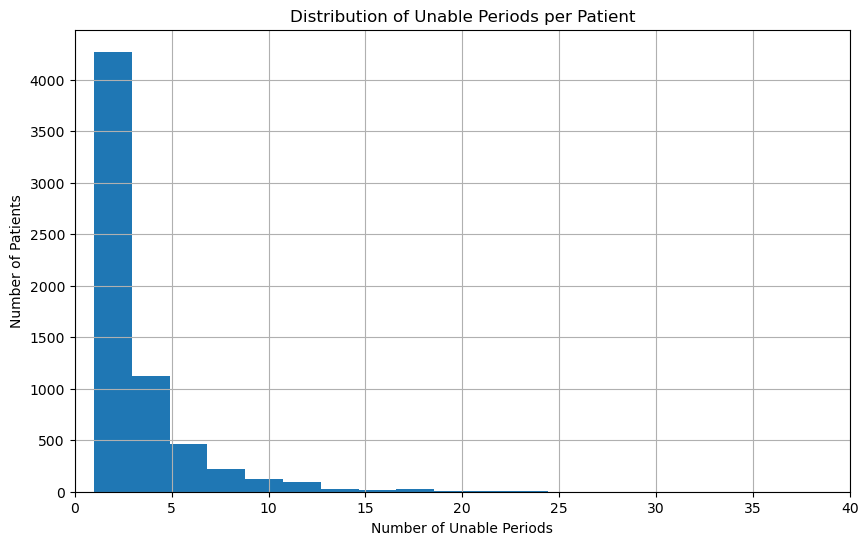

In [25]:
# find_unable_periods 함수 실행 후 바로 아래에 추가
print(result_df.info())
print(result_df.describe())

# unable 기간의 분포 시각화
result_df['unable_duration'] = (result_df['extubationtime(un)'] - result_df['intubationtime(un)']).dt.total_seconds() / 3600  # 시간 단위로 변환

plt.figure(figsize=(10, 6))
result_df['unable_duration'].hist(bins=50)
plt.title('Distribution of Unable Duration')
plt.xlabel('Duration (hours)')
plt.xlim([0, result_df['unable_duration'].max()])
plt.ylabel('Frequency')
plt.show()

# 환자별 unable 횟수 분포
patient_unable_counts = result_df.groupby('subject_id').size()
plt.figure(figsize=(10, 6))
patient_unable_counts.hist(bins=20)
plt.title('Distribution of Unable Periods per Patient')
plt.xlabel('Number of Unable Periods')
plt.xlim([0, patient_unable_counts.max()])
plt.ylabel('Number of Patients')
plt.show()


- 데이터를 더 잘 파악하기 위해 gender, 등 인구학적 컬럼 추가

In [26]:
import pandas as pd

# 기존 데이터 로드
result_df = pd.read_csv('./data/unable_periods.csv', parse_dates=['intubationtime(un)', 'extubationtime(un)'])

# 환자 정보 로드
patients = pd.read_csv('./data/patients.csv')
admissions = pd.read_csv('./data/admissions.csv', parse_dates=['admittime', 'dischtime', 'deathtime'])
icustays = pd.read_csv('./data/icustays.csv', parse_dates=['intime', 'outtime'])

# 필요한 정보만 선택
patients = patients[['subject_id', 'gender']]
admissions = admissions[['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime']]
icustays = icustays[['subject_id', 'hadm_id', 'stay_id', 'los']]

# 데이터 병합
result_df = (result_df
             .merge(patients, on='subject_id', how='left')
             .merge(admissions, on=['subject_id', 'hadm_id'], how='left')
             .merge(icustays, on=['subject_id', 'hadm_id', 'stay_id'], how='left'))

# 결과 저장
result_df.to_csv('./data/unable_periods_enriched.csv', index=False)

print("Enriched data saved to 'unable_periods_enriched.csv'")

Enriched data saved to 'unable_periods_enriched.csv'


#### intu_extu_duration(period) 컬럼 추가
- extubationtime(un) - intubationtime(un)

In [27]:
result_df['intu_extu_duration(period)'] = (result_df['extubationtime(un)'] - result_df['intubationtime(un)']).dt.total_seconds() / 3600 # hour 단위

#### to_reintubation(un) 컬럼 추가
- 시퀀스 내의 기준으로, n+1행의 intubationtime(un)에서 n행의 extubationtime(un)을 빼서 구함

In [28]:
# 다음 intubationtime 행 가져오기
result_df['next_intubationtime'] = result_df.groupby(['subject_id', 'hadm_id', 'stay_id'])['intubationtime(un)'].shift(-1)

# extubation과 다음 intubation 사이의 시간 계산
result_df['to_reintubation(un)'] = (result_df['next_intubationtime'] - result_df['extubationtime(un)']).dt.total_seconds() / 3600

# NULL을 0으로
result_df['to_reintubation(un)'] = result_df['to_reintubation(un)'].fillna(0)

# 불필요 컬럼 삭제
result_df = result_df.drop(columns=['next_intubationtime'])
result_df

,subject_id,hadm_id,stay_id,intubationtime(un),extubationtime(un),unableseq,gender,admittime,dischtime,deathtime,los,intu_extu_duration(period),to_reintubation(un)
0,10001884,26184834,37510196,2131-01-11 08:00:00,2131-01-12 17:30:00,1,F,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,9.171817,33.500000,10.500000
1,10001884,26184834,37510196,2131-01-13 04:00:00,2131-01-13 20:00:00,2,F,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,9.171817,16.000000,12.133333
2,10001884,26184834,37510196,2131-01-14 08:08:00,2131-01-17 20:09:00,3,F,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,9.171817,84.016667,27.850000
3,10001884,26184834,37510196,2131-01-19 00:00:00,2131-01-19 08:00:00,4,F,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,9.171817,8.000000,0.000000
4,10003400,23559586,38383343,2137-08-18 02:00:00,2137-08-21 16:00:00,1,F,2137-08-04 00:07:00,2137-09-02 17:05:00,2137-09-02 17:05:00,16.069838,86.000000,82.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17635,19999068,21606769,30143796,2161-08-25 17:13:00,2161-08-27 04:56:00,1,M,2161-08-24 04:10:00,2161-09-02 19:00:00,NaT,6.765324,35.716667,14.566667
17636,19999068,21606769,30143796,2161-08-27 19:30:00,2161-08-28 12:38:00,2,M,2161-08-24 04:10:00,2161-09-02 19:00:00,NaT,6.765324,17.133333,0.000000
17637,19999442,26785317,32336619,2148-11-19 23:00:00,2148-11-20 13:00:00,1,M,2148-11-19 10:00:00,2148-12-04 16:25:00,NaT,6.950370,14.000000,0.000000
17638,19999840,21033226,38978960,2164-09-12 10:11:00,2164-09-12 16:00:00,1,M,2164-09-10 13:47:00,2164-09-17 13:42:00,2164-09-17 13:42:00,5.297766,5.816667,12.083333


##### 가독성위해 컬럼 순서 변경

In [29]:
columns=['subject_id', 'hadm_id', 'stay_id', 'gender', 'los', 'admittime', 'intubationtime(un)', 'extubationtime(un)', 'intu_extu_duration(period)', 'to_reintubation(un)', 'unableseq', 'dischtime', 'deathtime']

result_df = result_df[columns]

result_df

,subject_id,hadm_id,stay_id,gender,los,admittime,intubationtime(un),extubationtime(un),intu_extu_duration(period),to_reintubation(un),unableseq,dischtime,deathtime
0,10001884,26184834,37510196,F,9.171817,2131-01-07 20:39:00,2131-01-11 08:00:00,2131-01-12 17:30:00,33.500000,10.500000,1,2131-01-20 05:15:00,2131-01-20 05:15:00
1,10001884,26184834,37510196,F,9.171817,2131-01-07 20:39:00,2131-01-13 04:00:00,2131-01-13 20:00:00,16.000000,12.133333,2,2131-01-20 05:15:00,2131-01-20 05:15:00
2,10001884,26184834,37510196,F,9.171817,2131-01-07 20:39:00,2131-01-14 08:08:00,2131-01-17 20:09:00,84.016667,27.850000,3,2131-01-20 05:15:00,2131-01-20 05:15:00
3,10001884,26184834,37510196,F,9.171817,2131-01-07 20:39:00,2131-01-19 00:00:00,2131-01-19 08:00:00,8.000000,0.000000,4,2131-01-20 05:15:00,2131-01-20 05:15:00
4,10003400,23559586,38383343,F,16.069838,2137-08-04 00:07:00,2137-08-18 02:00:00,2137-08-21 16:00:00,86.000000,82.000000,1,2137-09-02 17:05:00,2137-09-02 17:05:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17635,19999068,21606769,30143796,M,6.765324,2161-08-24 04:10:00,2161-08-25 17:13:00,2161-08-27 04:56:00,35.716667,14.566667,1,2161-09-02 19:00:00,NaT
17636,19999068,21606769,30143796,M,6.765324,2161-08-24 04:10:00,2161-08-27 19:30:00,2161-08-28 12:38:00,17.133333,0.000000,2,2161-09-02 19:00:00,NaT
17637,19999442,26785317,32336619,M,6.950370,2148-11-19 10:00:00,2148-11-19 23:00:00,2148-11-20 13:00:00,14.000000,0.000000,1,2148-12-04 16:25:00,NaT
17638,19999840,21033226,38978960,M,5.297766,2164-09-10 13:47:00,2164-09-12 10:11:00,2164-09-12 16:00:00,5.816667,12.083333,1,2164-09-17 13:42:00,2164-09-17 13:42:00


In [30]:
result_df.to_csv('./data/unable_intu_extu.csv', index=False, encoding='utf-8-sig')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17640 entries, 0 to 17639
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   subject_id                  17640 non-null  int64         
 1   hadm_id                     17640 non-null  int64         
 2   stay_id                     17640 non-null  int64         
 3   gender                      17640 non-null  object        
 4   los                         17640 non-null  float64       
 5   admittime                   17640 non-null  object        
 6   intubationtime(un)          17640 non-null  datetime64[ns]
 7   extubationtime(un)          17640 non-null  datetime64[ns]
 8   intu_extu_duration(period)  17640 non-null  float64       
 9   to_reintubation(un)         17640 non-null  float64       
 10  unableseq                   17640 non-null  int64         
 11  dischtime                   17640 non-null  object    

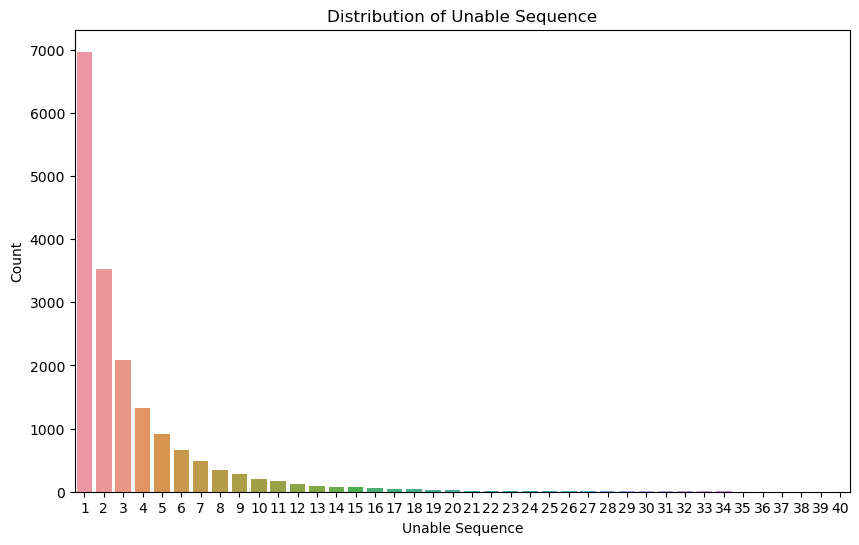

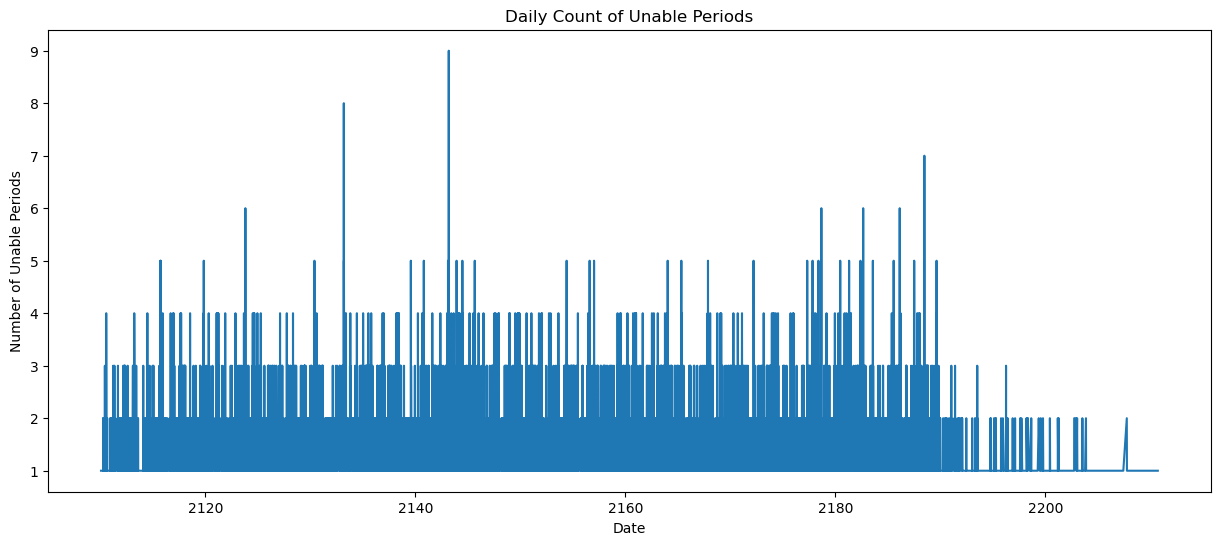

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CSV 파일 읽기
unable_intu_extu = pd.read_csv('./data/unable_intu_extu.csv', 
                               encoding='utf-8-sig',
                               parse_dates=['intubationtime(un)', 'extubationtime(un)'])

# 데이터 기본 정보 확인
print(unable_intu_extu.info())
print(unable_intu_extu.describe())

# 상위 10명의 환자 unable 횟수
print("Top 10 patients with most unable periods:")
print(patient_unable_counts.nlargest(10))

# unableseq 분포
plt.figure(figsize=(10, 6))
sns.countplot(x='unableseq', data=unable_intu_extu)
plt.title('Distribution of Unable Sequence')
plt.xlabel('Unable Sequence')
plt.ylabel('Count')
plt.show()

# 시간에 따른 unable 발생 추이
unable_intu_extu['intubation_date'] = unable_intu_extu['intubationtime(un)'].dt.date
daily_unable_count = unable_intu_extu.groupby('intubation_date').size()

plt.figure(figsize=(15, 6))
daily_unable_count.plot()
plt.title('Daily Count of Unable Periods')
plt.xlabel('Date')
plt.ylabel('Number of Unable Periods')
plt.show()

### 3. unable 로 추가된 time 을 추가 및 재배열에 활용하기
- 3-1. intubationtime, intubationtime(un), extubationtime, extubationtime(un)이 포함된 테이블 읽기
- 3-2. intubation-extubation 은 pairing 되어야 하므로 연속해서 intubation event가 있거나 연속해서 extubation event 가 있으면 에러로 볼 수 있음.
- 3-3. error 타입 정의하고 해결
- 3-4. pairing 및 seq 부여

#### 3-1. intubationtime, intubationtime_un, extubationtime, extubationtime_un 이 포함된 테이블 읽기

In [32]:
import pandas as pd

# CSV 파일 읽기, 날짜 컬럼 자동 파싱
unable_intu_extu = pd.read_csv('./data/unable_intu_extu.csv', 
                               encoding='utf-8-sig',
                               parse_dates=['intubationtime(un)', 'extubationtime(un)'])

print("Data loaded successfully. Shape:", unable_intu_extu.shape)
print("\nFirst few rows:")
print(unable_intu_extu.head())

Data loaded successfully. Shape: (17640, 13)

First few rows:
   subject_id   hadm_id   stay_id gender        los            admittime  \
0    10001884  26184834  37510196      F   9.171817  2131-01-07 20:39:00   
1    10001884  26184834  37510196      F   9.171817  2131-01-07 20:39:00   
2    10001884  26184834  37510196      F   9.171817  2131-01-07 20:39:00   
3    10001884  26184834  37510196      F   9.171817  2131-01-07 20:39:00   
4    10003400  23559586  38383343      F  16.069838  2137-08-04 00:07:00   

   intubationtime(un)  extubationtime(un)  intu_extu_duration(period)  \
0 2131-01-11 08:00:00 2131-01-12 17:30:00                   33.500000   
1 2131-01-13 04:00:00 2131-01-13 20:00:00                   16.000000   
2 2131-01-14 08:08:00 2131-01-17 20:09:00                   84.016667   
3 2131-01-19 00:00:00 2131-01-19 08:00:00                    8.000000   
4 2137-08-18 02:00:00 2137-08-21 16:00:00                   86.000000   

   to_reintubation(un)  unableseq         

<Figure size 2000x1000 with 0 Axes>

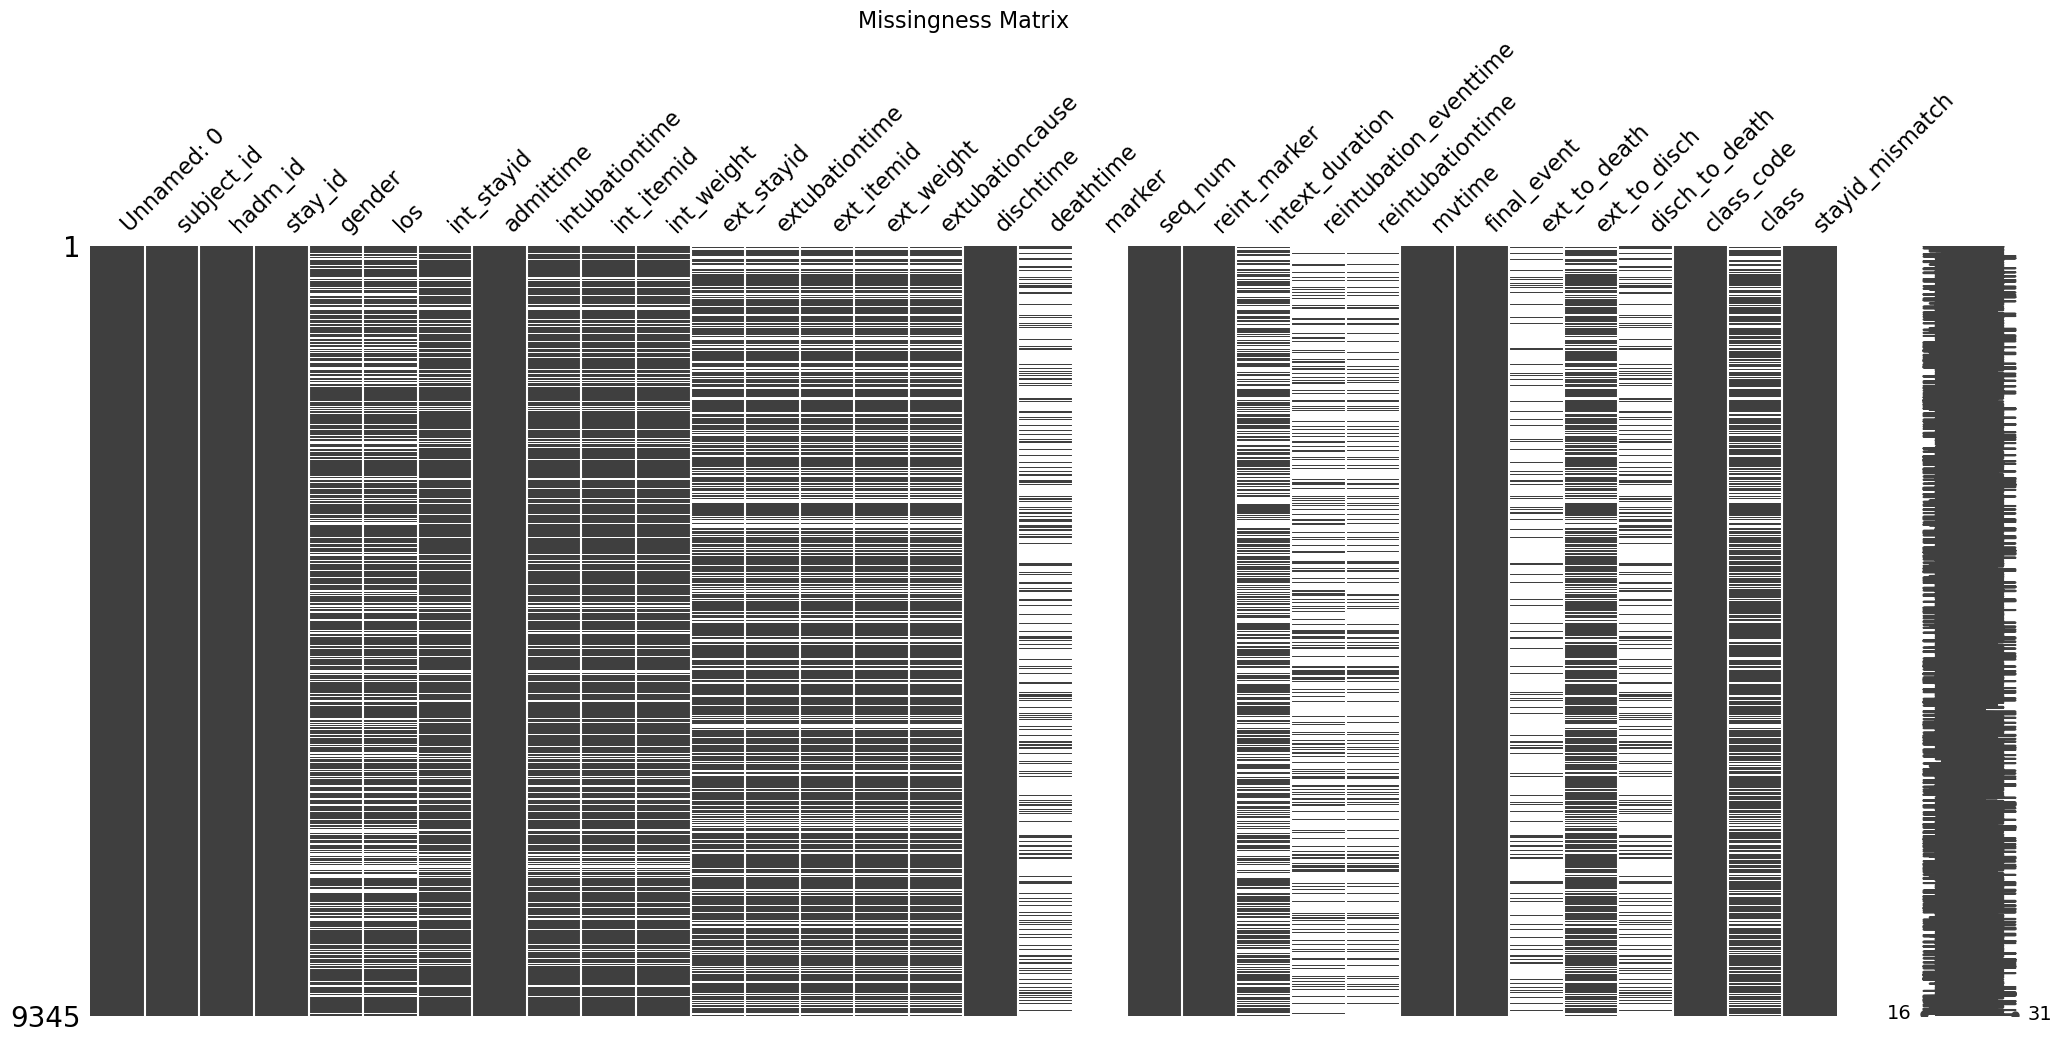

In [33]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

# 00_subjectlist1_prepare02_alignment.ipynb 파일에서 최종적으로 저장되는 파일을 불러옴.
before_reconstruction = pd.read_csv('./data/subjectlist2_intextevents.csv')

# 결측치 행렬 생성
plt.figure(figsize=(20, 10))
msno.matrix(before_reconstruction)
plt.title('Missingness Matrix', fontsize=16)
plt.show()

#### 3-2. intubation-extubation 은 pairing 되어야 하므로 연속해서 intubation event가 있거나 연속해서 extubation event 가 있으면 에러로 볼 수 있음.


In [38]:
#기존 intubation_extubaion 테이블 읽기
intubation_extubation = pd.read_csv('./data/intubation_extubation_before_unable.csv', parse_dates = ['intubationtime','extubation'])
intubation_extubation = util.create_stay_id(intubation_extubation)   # stay id 만들어 넣기

ValueError: Missing column provided to 'parse_dates': 'extubation'

In [ ]:
import src_unable as pairing   # 삽관 발관 페어링 관련 모듈
from src_unable import reintubation as rnt   # 재삽관 시간 계산 관련 모듈
from src_unable import flag   
from src_unable import subject_classification as cls

In [ ]:
# flag 생성
table = flag.add_columns(intubation_extubation, before_reconstruction) # 비교에 필요한 컬럼 생성
table = flag.drop_duplication(table) # flag 생성 전 중복 데이터 삭제(모든 컬럼의 값이 동일한 행같은 경우)
table = flag.alignment_intuextu(table) # 정렬 (삽/발관 시간이 같은 경우 intubation이 먼저 나옴)
table = flag.duplicates_row_flag(table) # 연속해서 intubation이 있거나 extubation이 연속해서 있는 경우 dup_flag 생성
table = flag.time_diff(table) # dup_flag인 행과 그 다음 행의 시간 차이 계산

c:\Users\inhae\Desktop\extubationfailure\after\intubation_error\src_unable\flag.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intubation_df['data_type']='real'
c:\Users\inhae\Desktop\extubationfailure\after\intubation_error\src_unable\flag.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extubation_df['data_type']='real'
c:\Users\inhae\Desktop\extubationfailure\after\intubation_error\src_unable\flag.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [ ]:
print(f'intubation or extubation 중복인 경우: {round(table[table.dup_flag].shape[0] / table.shape[0] * 100, 2)}%')
print()
table.info()

intubation or extubation 중복인 경우: 27.72%

<class 'pandas.core.frame.DataFrame'>
Index: 48146 entries, 0 to 48145
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   subject_id       48146 non-null  int64         
 1   hadm_id          48146 non-null  int64         
 2   stay_id          48146 non-null  int64         
 3   time             48146 non-null  datetime64[ns]
 4   data_type        48146 non-null  object        
 5   event_type       48146 non-null  object        
 6   extubationcause  6747 non-null   object        
 7   dup_flag         48146 non-null  bool          
 8   time_diff        13344 non-null  object        
dtypes: bool(1), datetime64[ns](1), int64(3), object(4)
memory usage: 4.4+ MB


#### 3-3. error 타입 정의하고 해결


In [ ]:
def duplicate_intu(table):
    table.time_diff = pd.to_timedelta(table.time_diff)

    # intubation & 중복인 경우
    table_intu_dup = table[(table.event_type == 'intubation') & (table.dup_flag)]
    intu_mean = table[(table.event_type == 'intubation')].time_diff.mean()

    table['delete'] = False
    table['add_extu'] = False

    delete_idx = []

    for idx, row in table_intu_dup.iterrows():
        group = []
        next_idx = idx + 1

        # 3개 이상의 행이 중복인 경우
        if idx in delete_idx:
            pre_idx = idx - 1
            next_idx = idx + 1
            table.loc[[pre_idx, next_idx]]

            # time_diff(3시간 30분)가 평균보다 작은 경우
            if (table.loc[[pre_idx, next_idx]].time.diff() <= intu_mean).any():

                # data_type이 다른 경우는 삭제(unable intu - 원본 intu | 원본 intu - unable intu)
                if (table.loc[pre_idx].data_type != table.loc[next_idx]).data_type:
                    group.append({"index": pre_idx,"data_type": table.loc[pre_idx].data_type})
                    group.append({"index": next_idx,"data_type": table.loc[next_idx].data_type})
                    dataframe = pd.DataFrame(group)

                    cond_idx = dataframe[dataframe.data_type == 'unable']['index'].values[0]
                    table.loc[cond_idx,'delete'] = True

                    table.loc[pre_idx,'dup_flag'] = False # flag 초기화
                    table.loc[pre_idx,'time_diff'] = pd.NaT # flag 초기화
                else:
                    # 원본 intubation이 연달아 나오는 경우, extu 추가
                    if table.loc[pre_idx].data_type == 'real':

                        table.loc[next_idx,'add_extu'] = True
                        table.loc[pre_idx,'dup_flag'] = False # flag 초기화
                        table.loc[pre_idx,'time_diff'] = pd.NaT # flag 초기화

            else:
                # data_type에 관계없이 extu 추가
                table.loc[next_idx,'add_extu'] = True
                table.loc[pre_idx,'dup_flag'] = False # flag 초기화
                table.loc[pre_idx,'time_diff'] = pd.NaT # flag 초기화

        else:
            # time_diff(3시간 30분)가 평균보다 작은 경우
            if row.time_diff <= intu_mean: 
                # data_type이 다른 경우는 삭제(unable intu - 원본 intu | 원본 intu - unable intu)
                if row.data_type != table.loc[next_idx].data_type: 

                    group.append({"index": idx,"data_type": row.data_type})
                    group.append({"index": next_idx,"data_type": table.loc[next_idx].data_type})
                    dataframe = pd.DataFrame(group)

                    cond_idx = dataframe[dataframe.data_type == 'unable']['index'].values[0]
                    table.loc[cond_idx,'delete'] = True
                    delete_idx.append(cond_idx)
                    table.loc[idx,'dup_flag'] = False # flag 초기화
                    table.loc[idx,'time_diff'] = pd.NaT # flag 초기화
                
                else:
                    # 원본 intubation이 연달아 나오는 경우, extu 추가
                    if row.data_type == 'real':

                        table.loc[next_idx,'add_extu'] = True
                        table.loc[idx,'dup_flag'] = False # flag 초기화
                        table.loc[idx,'time_diff'] = pd.NaT # flag 초기화

                    else:
                        print(row.hadm_id, 'unable이 두개 연속') # 아무것도 없어야 함

            # time_diff(3시간 30분)가 평균보다 큰 경우
            else:
                # data_type에 관계없이 extu 추가
                table.loc[next_idx,'add_extu'] = True
                table.loc[idx,'dup_flag'] = False # flag 초기화
                table.loc[idx,'time_diff'] = pd.NaT # flag 초기화

    # extubation 추가
    table_copy = table[table.add_extu]

    table_copy.loc[:,'time'] = table_copy.time - pd.Timedelta(minutes = 1)
    table_copy.loc[:,'data_type'] = 'added'
    table_copy.loc[:,'event_type'] = 'extubation'
    table_copy.loc[:,'dup_flag'] = False
    table_copy.loc[:,'time_diff'] = pd.NaT

    table = pd.concat([table,table_copy]).sort_values(by=['hadm_id','stay_id','time'])#.reset_index(drop = True)

    # 조건에 맞는 행 삭제
    table = table[~(table.delete)]#.reset_index(drop = True)

    return table

####  extubaiton 추가 및 unable intubation 삭제 
- 뒤의 intubationtime -1분으로 extubation 추가
- delete 컬럼이 True인 행 삭제

In [ ]:
table = duplicate_intu(table)
table[(table.event_type == 'intubation') & (table.dup_flag)] # 아무것도 안 나와야 함

,subject_id,hadm_id,stay_id,time,data_type,event_type,extubationcause,dup_flag,time_diff,delete,add_extu


- (B). extubation이 중복인 경우
- (B-1). 중복이 2개인 경우 (intubation - extubation - extubation 같이 2개의 extubation 연달아 나오는 경우)
    - 원본 extubation - unable extubation 순서인 경우
        - extubation이 Unplanned이면, intubation 추가
        - planned면, time_diff가 평균시간(4시간)보다 작으면 unable 삭제, 크면 앞의 extubationtime +1분으로 intubation 추가

    - unable extubation - 원본 extubatione 순서인 경우
        - time_diff가 평균시간(4시간)보다 작으면 unable 삭제, 크면 앞의 extubationtime +1분으로 intubation 추가

    - real extubation이 연달아 나오는 경우
        - 원래 extubation이 Unplanned이면, intubation 추가
        - planned면, time_diff가 평균시간(4시간)보다 작으면 unable 삭제, 크면 앞의 extubationtime +1분으로 intubation 추가

- (B-2) 중복이 3개
    - 위의 조건을 따름

In [ ]:
def duplicate_extu(table):
    table.time_diff = pd.to_timedelta(table.time_diff)

    # extubation & 중복인 경우
    table_extu_dup = table[(table.event_type == 'extubation') & (table.dup_flag)]
    extu_mean = table[(table.event_type == 'extubation')].time_diff.mean()

    table['delete'] = False
    table['add_intu'] = False

    delete_idx= []

    for idx, row in table_extu_dup.iterrows():
        next_idx = idx + 1

        # 3개 이상의 행이 중복인 경우
        if idx in delete_idx:
            pre_idx = idx - 1
            next_idx = idx + 1
            pre_row = table.loc[pre_idx]
            next_row = table.loc[next_idx]

            # 1. real-unable인 경우 (real extubaion이 unplanned일 경우는 intubation 추가, 그외엔 평균시간에 따라 처리)
            if (pre_row.data_type == 'real') & (next_row.data_type == 'unable'):
                if row.extubationcause != 'Planned Extubation': 
                    table.loc[pre_idx,'add_intu'] = True

                    table.loc[pre_idx,'dup_flag'] = False # flag 초기화
                    table.loc[pre_idx,'time_diff'] = pd.NaT # flag 초기화

                else:
                    # 평균시간(extu_mean)보다 작은 경우
                    if (table.loc[[pre_idx, next_idx]].time.diff() <= extu_mean).any():
                        table.loc[next_idx,'delete'] = True
                        table.loc[pre_idx,'dup_flag'] = False # flag 초기화
                        table.loc[pre_idx,'time_diff'] = pd.NaT # flag 초기화

                    # 평균시간(extu_mean)보다 큰 경우
                    else:
                        table.loc[pre_idx,'add_intu'] = True
                        table.loc[pre_idx,'dup_flag'] = False # flag 초기화
                        table.loc[pre_idx,'time_diff'] = pd.NaT # flag 초기화

            # 2. unable - real인 경우 (평균시간보다 작은 경우는 unable extubation 삭제, 큰 경우는 intubation 추가)
            elif (pre_row.data_type == 'unable') & (next_row.data_type == 'real'):

                # 평균시간(extu_mean)보다 작은 경우
                if (table.loc[[pre_idx, next_idx]].time.diff() <= extu_mean).any():
                    table.loc[pre_idx,'delete'] = True
                    table.loc[pre_idx,'dup_flag'] = False # flag 초기화
                    table.loc[pre_idx,'time_diff'] = pd.NaT # flag 초기화

                # 평균시간(extu_mean)보다 큰 경우
                else:
                    table.loc[pre_idx,'add_intu'] = True
                    table.loc[pre_idx,'dup_flag'] = False # flag 초기화
                    table.loc[pre_idx,'time_diff'] = pd.NaT # flag 초기화

            # 3. real extubation이 연달아 나오는 경우 (real - real, 삭제하지 않고 intubation 추가)
            elif (pre_row.data_type == 'real') & (next_row.data_type == 'real'):
                table.loc[pre_idx,'add_intu'] = True
                table.loc[pre_idx,'dup_flag'] = False # flag 초기화
                table.loc[pre_idx,'time_diff'] = pd.NaT # flag 초기화

            else:
                print(row.hadm_id) # 아무것도 안 나와야 함

        # 2개 행이 중복인 경우
        else:
            # 1. real-unable인 경우 (real extubaion이 unplanned일 경우는 intubation 추가, 그외엔 평균시간에 따라 처리)
            if (row.data_type == 'real') & (table.loc[next_idx].data_type == 'unable'):
                if row.extubationcause == 'Unplanned Extubation':
                    table.loc[idx,'add_intu'] = True
                    table.loc[idx,'dup_flag'] = False # flag 초기화
                    table.loc[idx,'time_diff'] = pd.NaT # flag 초기화

                else:
                    # 평균시간(extu_mean)보다 작은 경우
                    if row.time_diff <= extu_mean:
                        table.loc[next_idx,'delete'] = True
                        delete_idx.append(next_idx)
                        table.loc[idx,'dup_flag'] = False # flag 초기화
                        table.loc[idx,'time_diff'] = pd.NaT # flag 초기화

                    # 평균시간(extu_mean)보다 큰 경우
                    else:
                        table.loc[idx,'add_intu'] = True
                        table.loc[idx,'dup_flag'] = False # flag 초기화
                        table.loc[idx,'time_diff'] = pd.NaT # flag 초기화

            # 2. unable - real인 경우 (평균시간보다 작은 경우는 unable extubation 삭제, 큰 경우는 intubation 추가)
            elif (row.data_type == 'unable') & (table.loc[next_idx].data_type == 'real'):
                
                # 평균시간(extu_mean)보다 작은 경우
                if row.time_diff <= extu_mean:
                    table.loc[idx,'delete'] = True
                    delete_idx.append(idx)
                    table.loc[idx,'dup_flag'] = False # flag 초기화
                    table.loc[idx,'time_diff'] = pd.NaT # flag 초기화

                # 평균시간(extu_mean)보다 큰 경우
                else:
                    table.loc[idx,'add_intu'] = True
                    table.loc[idx,'dup_flag'] = False # flag 초기화
                    table.loc[idx,'time_diff'] = pd.NaT # flag 초기화

            # 3. real extubation이 연달아 나오는 경우 (real - real, 삭제하지 않고 intubation 추가)
            elif (row.data_type == 'real') & (table.loc[next_idx].data_type == 'real'):
                table.loc[idx,'add_intu'] = True
                table.loc[idx,'dup_flag'] = False # flag 초기화
                table.loc[idx,'time_diff'] = pd.NaT # flag 초기화

            else:
                print(row.hadm_id) # 아무것도 안 나와야 함

    # intubation 추가
    table_copy = table[table.add_intu]

    table_copy.loc[:,'time'] = table_copy.time + pd.Timedelta(minutes = 1)
    table_copy.loc[:,'data_type'] = 'added'
    table_copy.loc[:,'event_type'] = 'intubation'
    table_copy.loc[:,'dup_flag'] = False

    table_copy.loc[:,'time_diff'] = pd.NaT
    table_copy.loc[:,'extubationcause'] = None

    table = pd.concat([table,table_copy]).sort_values(by=['hadm_id','stay_id','time']).reset_index(drop = True)

    # 조건에 맞는 행 삭제
    table = table[~(table.delete)].reset_index(drop = True)

    return table

#### intubation 추가 및 unable extubation 삭제

In [ ]:
table = duplicate_extu(table)
table[(table.event_type == 'extubation') & (table.dup_flag)] # 아무것도 안 나와야 함

table = flag.alignment_intuextu(table) # 재정렬
table = flag.duplicates_row_flag(table) # 오류 확인을 위해 새로운 flag 생성

table[(table.dup_flag)] # 최종 확인, 아무것도 안 나와야 함

,subject_id,hadm_id,stay_id,time,data_type,event_type,extubationcause,dup_flag,time_diff,delete,add_extu,add_intu


,subject_id,hadm_id,stay_id,time,data_type,event_type,extubationcause,dup_flag,time_diff,delete,add_extu,add_intu


- (C). stay_id가 하나인 경우
- 참고할 unable 삽/발관과 원본 삽/발관이 존재하지 않음
- 따라서 icu 퇴실, 입실 시간으로 결측 행을 채움
- 그럼에도 채워지지 않는 행은 퇴원 시간으로 채움

In [ ]:
# 데이터 불러오기
adults_icu = pd.read_csv('./data/adults_icu.csv', parse_dates = ['dischtime'])   # 성인 환자 정보

In [ ]:
intu_last = table.groupby('stay_id').tail(1)[table.groupby('stay_id').tail(1).event_type == 'intubation'] # intubation으로 끝나는 경우
extu_first = table.groupby('stay_id').head(1)[table.groupby('stay_id').head(1).event_type == 'extubation'] # extubation으로 시작하는 경우

list = []

for idx, row in intu_last.iterrows():
    icu = icustays[icustays.stay_id == row.stay_id]

    # icu outtime이 마지막 행의 intubation 시간보다 클 때만 추가
    if (icu.outtime >= row.time).any():
        list.append({'subject_id': row.subject_id,'hadm_id': row.hadm_id,'stay_id': row.stay_id,'time': icu.outtime.values[0],'data_type':'icu_out','event_type': 'extubation', 'dup_flag':False})
    else:
        dischtime = adults_icu[adults_icu.stay_id == row.stay_id].dischtime
        list.append({'subject_id': row.subject_id,'hadm_id': row.hadm_id,'stay_id': row.stay_id,'time': dischtime.values[0],'data_type':'dischtime','event_type': 'extubation', 'dup_flag':False})

for idx, row in extu_first.iterrows():
    icu = icustays[icustays.stay_id == row.stay_id]

    # icu intime이 처음 행의 extubation 시간보다 작을 때만 추가
    if (icu.intime <= row.time).any():
        list.append({'subject_id': row.subject_id,'hadm_id': row.hadm_id,'stay_id': row.stay_id,'time': icu.intime.values[0],'data_type':'icu_in','event_type': 'intubation', 'dup_flag':False})
    else:
        print('추가할 intubation이 존재하지 않음(stay_id):', row.stay_id) # 아무것도 없어야 함

In [ ]:
icu_data = pd.DataFrame(list)
final_table = pd.concat([table, icu_data])
final_table = flag.alignment_intuextu(final_table) # 재정렬

final_table = flag.drop_duplication(final_table)
final_table[final_table.dup_flag] # 아무것도 없어야 함

,subject_id,hadm_id,stay_id,time,data_type,event_type,extubationcause,dup_flag,time_diff,delete,add_extu,add_intu


#### 3-4. pairing 및 seq 부여

- subjectlist2 : unableevents 를 추가하고, pairing 하고 seq부여하고, 이 과정에서 생기는 에러 해결
    - table에서 발생한 error를 모두(?) 해결
    - 테이블 완결을 위한 환자 관련 변수들 추가

In [ ]:
# intubation, extubation 페어링
intubation_table = final_table[final_table.event_type == 'intubation'].rename(columns={'time':'intubationtime'})
extubation_table = final_table[final_table.event_type == 'extubation'].rename(columns = {'time':'extubationtime'})

# 테이블 시간 정렬
intubation_df = intubation_table.sort_values('intubationtime')
extubation_df = extubation_table.sort_values('extubationtime')

paired_df = pd.merge_asof(
    intubation_df,
    extubation_df,
    left_on='intubationtime',
    right_on='extubationtime',
    by=['subject_id', 'hadm_id', 'stay_id'],  # 같은 subject_id, hadm_id, stay_id 기준으로
    direction='forward'  # intubation 이후의 가장 가까운 extubation 시간과 페어링
)

final_table = paired_df[['subject_id','hadm_id','stay_id','intubationtime','extubationtime','data_type_x','data_type_y','extubationcause_y']]
final_table.rename(columns = {'data_type_x':'intu_data', 'data_type_y':'extu_data', 'extubationcause_y':'extubationcause'}, inplace = True)
final_table.sort_values(by = ['subject_id', 'hadm_id', 'stay_id','intubationtime'], inplace = True)
final_table.reset_index(drop = True, inplace = True)

C:\Users\inhae\AppData\Local\Temp\ipykernel_13324\1337356591.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_table.rename(columns = {'data_type_x':'intu_data', 'data_type_y':'extu_data', 'extubationcause_y':'extubationcause'}, inplace = True)
C:\Users\inhae\AppData\Local\Temp\ipykernel_13324\1337356591.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_table.sort_values(by = ['subject_id', 'hadm_id', 'stay_id','intubationtime'], inplace = True)


In [ ]:
final_table.to_csv('./data/final_table.csv')

- 성별 등 환자 정보 추가

In [ ]:
# 데이터 불러오기
adults_icu = pd.read_csv('./data/adults_icu.csv')   # 성인 환자 정보

adults_icu: (73181, 13)
intubation_extubation: (11528, 16)


In [ ]:
adults_icu_filtered = adults_icu.drop(columns=['admittime', 'dischtime', 'deathtime'])
adults_icu_filtered = adults_icu_filtered.drop_duplicates(subset = ["subject_id","hadm_id","stay_id"])

# 칼럼 순서 변경
final_columns = ['subject_id', 'hadm_id', 'stay_id', 'gender', 'los', 'admittime', 
                 'intubationtime','extubationtime','extubationcause', 'dischtime','deathtime']

merge1 = pd.merge(adults_icu_filtered, final_table, on = ['subject_id','hadm_id','stay_id'])
joined_df = pd.merge(merge1, final_table, on = ['hadm_id'])[final_columns]
joined_df

,subject_id,hadm_id,stay_id,gender,los,admittime,intubationtime,extubationtime,extubationcause,dischtime,deathtime
0,10001884,26184834.0,37510196.0,F,9.171817,2131-01-07 20:39:00,2131-01-11 04:30:00,2131-01-12 17:40:00,Planned Extubation,2131-01-20 05:15:00,2131-01-20 05:15:00
1,10001884,26184834.0,37510196.0,F,9.171817,2131-01-07 20:39:00,2131-01-13 04:00:00,2131-01-13 20:00:00,NaN,2131-01-20 05:15:00,2131-01-20 05:15:00
2,10001884,26184834.0,37510196.0,F,9.171817,2131-01-07 20:39:00,2131-01-14 08:08:00,2131-01-17 20:09:00,NaN,2131-01-20 05:15:00,2131-01-20 05:15:00
3,10001884,26184834.0,37510196.0,F,9.171817,2131-01-07 20:39:00,2131-01-19 00:00:00,2131-01-19 08:00:00,NaN,2131-01-20 05:15:00,2131-01-20 05:15:00
4,10003400,23559586.0,38383343.0,F,16.069838,2137-08-04 00:07:00,2137-08-17 21:21:00,2137-08-18 01:59:00,NaN,2137-09-02 17:05:00,2137-09-02 17:05:00
...,...,...,...,...,...,...,...,...,...,...,...
21077,19999068,21606769.0,30143796.0,M,6.765324,2161-08-24 04:10:00,2161-08-27 19:30:00,2161-08-28 13:35:00,Planned Extubation,2161-09-02 19:00:00,NaT
21078,19999442,26785317.0,32336619.0,M,6.950370,2148-11-19 10:00:00,2148-11-19 19:00:00,2148-11-19 22:59:00,NaN,2148-12-04 16:25:00,NaT
21079,19999442,26785317.0,32336619.0,M,6.950370,2148-11-19 10:00:00,2148-11-19 23:00:00,2148-11-20 14:15:00,Planned Extubation,2148-12-04 16:25:00,NaT
21080,19999840,21033226.0,38978960.0,M,5.297766,2164-09-10 13:47:00,2164-09-12 09:40:00,2164-09-12 16:00:00,NaN,2164-09-17 13:42:00,2164-09-17 13:42:00


- Reintubationtime  관련 변수들 계산, 데이터 정리

In [ ]:
def get_reintubation(df):
    start_time = time.time()   # 소요시간 계산
    grouped_df = df.groupby(['hadm_id', 'stay_id'])

    df_list = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
            
        for _, patient_df in tqdm(grouped_df, desc="Fetching reintubation data..."):

            patient_df = rnt.create_reintubation_columns(patient_df)   # reintubationtime 칼럼 초기화 (reint_marker, mvtime, 다음 발관 시간, 재삽관 시간)
            patient_df = rnt.get_mvtime(patient_df)   # 삽관시간과 발관시간의 차이 계산
            patient_df = rnt.carryover_next_intubationtime(patient_df)   # 다음 삽관시간 가져오기
            patient_df = rnt.get_reint_marker(patient_df)   # 환자별로 재삽관이 존재하는지 마킹
            patient_df = rnt.get_reintubationtime(patient_df)   # 재삽관 시간 계산하기
            
            df_list.append(patient_df)

        # 환자별 데이터 하나의 데이터프레임으로 합치기
        reintubation_df = pd.concat(df_list)
        reintubation_df = reintubation_df.reset_index(drop=True)

        # 각 그룹별로 시퀀스 넘버링 해주기
        reintubation_df['seq_num'] = reintubation_df.groupby(['hadm_id', 'stay_id']).cumcount() + 1
    
    print("--- RUNTIME: %.2f seconds ---" % round(time.time() - start_time, 2))
        
    return reintubation_df

In [ ]:
reintubation_unable = get_reintubation(joined_df)
reintubation_unable.info()

Fetching reintubation data...: 100%|██████████| 6976/6976 [00:17<00:00, 388.79it/s]


--- RUNTIME: 21.19 seconds ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21082 entries, 0 to 21081
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   subject_id              21082 non-null  int64         
 1   hadm_id                 21082 non-null  float64       
 2   stay_id                 21082 non-null  float64       
 3   gender                  21082 non-null  object        
 4   los                     21082 non-null  float64       
 5   admittime               21082 non-null  datetime64[ns]
 6   intubationtime          21082 non-null  datetime64[ns]
 7   extubationtime          21082 non-null  datetime64[ns]
 8   extubationcause         6748 non-null   object        
 9   dischtime               21082 non-null  datetime64[ns]
 10  deathtime               5784 non-null   datetime64[ns]
 11  reint_marker            21082 non-null  bool          
 12  mvtime         

In [ ]:
reintubation_unable.to_csv('./data/reintubation_unable.csv')

- 환자군 분류 (ext failure, non-failure, etc.)

분류 코드
11 재삽관 없이 발관후 48시간 넘어 퇴원 | nonfailure

121 재삽관 없이 발관후 48시간 이내 사망 X | nonfailure

1221 재삽관 없이 발관후 24시간 이내 사망 | death

1222 재삽관 없이 발관후 24~48시간 이내 사망 | death

211 48시간 이내 재삽관 | failure

212 48시간 너머 재삽관 | nonfailure

221 최종 발관 이후 48시간 넘어 퇴원 | nonfailure

2221 최종 발관 이후 48시간 이내 사망 X | nonfailure

22221 최종 발관 이후 24시간 이내 사망 | death

22222 최종 발관 이후 24~48시간 이내 사망 | death

999 (null case)현발관-다음발관이 48시간 이내 | Failure

998 (null case)현삽관-다음삽관이 48시간 이내 | Failure

9999 (null case) non-failure 판단 불가 | 제거

In [ ]:
# 데이터 임포트
reintubation_unable = pd.read_csv('./data/reintubation_unable.csv', index_col=0, \
                               parse_dates=['intubationtime', 'extubationtime', \
                                            'admittime', 'dischtime', 'deathtime'])

print(reintubation_unable.shape)   # (21082, 16) 

FileNotFoundError: [Errno 2] No such file or directory: './data/reintubation_unable.csv'

In [ ]:
def categorize_patients(df):
    # 분류 코드 기준
    categories = {
        "nonfailure": [11, 121, 212, 221, 2221],
        "failure": [211, 999, 998],
        "death": [1221, 1222, 22221, 22222]
    }

    start_time = time.time()   # 소요시간 계산

    # df = imp.init_marker(df)   # 'marker' 칼럼 생성 (결측치 대체 로그가 저장됨)
    grouped_df = df.groupby(['subject_id', 'hadm_id'])

    df_list = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
            
        for _, patient_df in tqdm(grouped_df, desc="Categorizing extubation failure vs non-failure..."):

            patient_df = cls.init_class_columns(patient_df)   # flag_mvtime_state, ext_to_death, ext_to_disch, disch_to_death, class_code 칼럼 초기화
            patient_df = cls.fill_class_columns(patient_df)   # 초기화한 칼럼 값(flag_mvtime_state, ext_to_death, ext_to_disch, disch_to_death) 계산해서 채워주기
            patient_df = cls.classify_patients(patient_df)   # 행별로 케이스 분류해서 class_code 입력해주는 코드
            patient_df = cls.categorize_code(patient_df, categories)   # class_code 기반으로 extubation failure, non-failure 분류해주는 코드
            df_list.append(patient_df)

        # 환자별 데이터 하나의 데이터프레임으로 합치기
        subjects_df = pd.concat(df_list)
        subjects_df = subjects_df.reset_index(drop=True)

    
    print("--- RUNTIME: %.2f seconds ---" % round(time.time() - start_time, 2))
        
    return subjects_df

In [ ]:
subjectlist2_unable = categorize_patients(reintubation_unable)

print(f'Processed subjectlist1: {subjectlist2_unable.shape}')   # (21082, 22)

subjectlist2_unable.columns

Categorizing extubation failure vs non-failure...: 100%|██████████| 6358/6358 [00:59<00:00, 106.31it/s]


--- RUNTIME: 63.31 seconds ---
Processed subjectlist1: (21082, 23)


Index(['subject_id', 'hadm_id', 'stay_id', 'gender', 'los', 'admittime',
       'intubationtime', 'extubationtime', 'extubationcause', 'dischtime',
       'deathtime', 'reint_marker', 'mvtime', 'reintubation_eventtime',
       'reintubationtime', 'seq_num', 'mvtime_state', 'final_event',
       'ext_to_death', 'ext_to_disch', 'disch_to_death', 'class_code',
       'class'],
      dtype='object')

In [ ]:
# 비논리적 데이터 삭제
subjectlist2_unable = subjectlist2_unable[((subjectlist2_unable.mvtime.isna()) | (subjectlist2_unable.mvtime > 0)) &\
              ((subjectlist2_unable.reintubationtime.isna()) | (subjectlist2_unable.reintubationtime >= 0))]

In [ ]:
# 데이터 저장
sub2list_unable = subjectlist2_unable >> select('subject_id','hadm_id',\
                                  'stay_id', 'admittime', 'dischtime')
sub2list_unable = sub2list_unable.drop_duplicates(subset='stay_id')   # remove dup

subjectlist2_unable.to_csv('./data/intubation_extubation_after_reconstruction.csv.csv')   # 삽관발관 포함 에러정의까지 한 파일?? 다 해결한 파일??
sub2list_unable.to_csv('./data/sub2list_unable.csv')   # 고유 환자리스트

In [ ]:
#   intubation_extubation_before_reconstruction(imputation).csv sub1
#   다해결이 되었으면 intubation_extubation_after_reconstruction.csv sub2